## 목표 : 다중 속성/피쳐를 기반으로 수치값 예측
- 데이터 : fish.csv
- 피쳐 : 4개 Length, Diagonal, Height, Weight
- 타켓 : 수치값 Weight
- 학습유형 : 지도학습 + 회귀
- 알고리즘 : 데이터를 확인 후 결정


### (1) 모듈 로딩  및 데이터 준비
<hr>

In [124]:
from sklearnex import patch_sklearn, unpatch_sklearn
patch_sklearn()

import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.linear_model import LinearRegression


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [125]:
filename = '../data/fish.csv'

df = pd.read_csv(filename)

mask = df['Species'] == 'Bream'
df = df[mask][df.columns[1:]]
df.info()



<class 'pandas.core.frame.DataFrame'>
Index: 35 entries, 0 to 34
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Weight    35 non-null     float64
 1   Length    35 non-null     float64
 2   Diagonal  35 non-null     float64
 3   Height    35 non-null     float64
 4   Width     35 non-null     float64
dtypes: float64(5)
memory usage: 1.6 KB


### (2) 데이터 확인
<hr>

- 타켓과 피쳐 관계 => 상관계수, 시각화

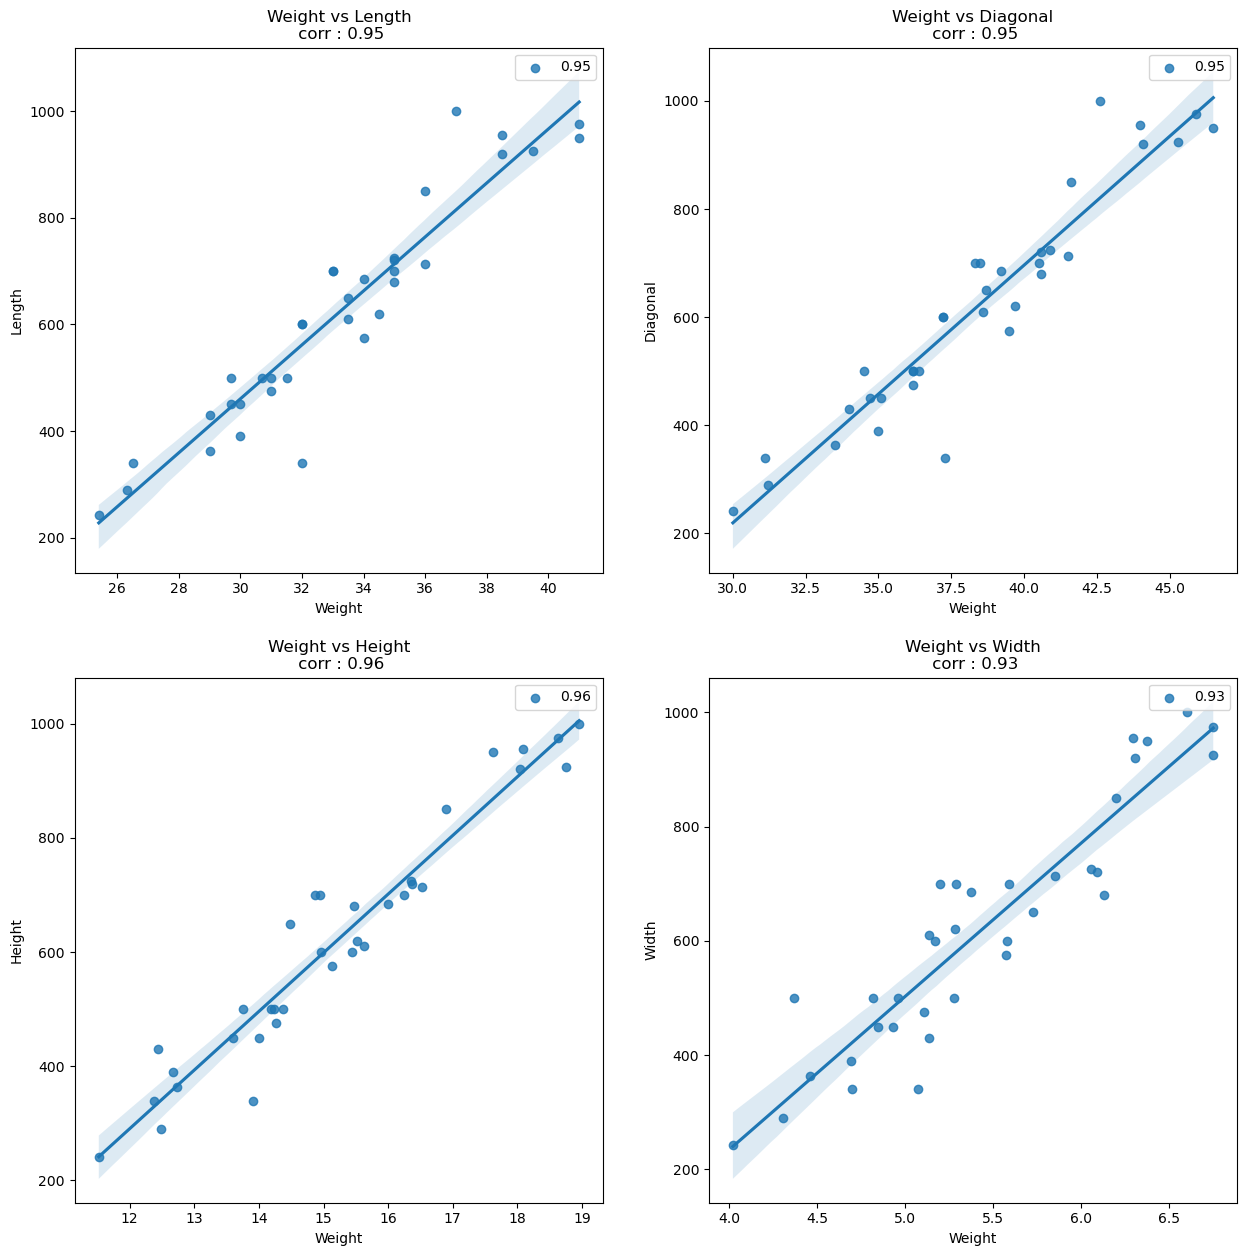

In [126]:
# 피쳐와 타켓과의 관계 정도를 시각화 및 수치값으로 표기 및 출력
# 매개변수 : 행수, 열수, 데이터프레임, 타켓, 피쳐리스트, 상관계수값
# 반환 : 없음

def features_print(
    rows:int, 
    cols:int, 
    df:pd.DataFrame, 
    target:str, 
    features:list, 
    corr_list:list,
    ):
    plt.figure(figsize=(15, 15))
    for idx in range(len(features)):
        plt.subplot(rows, cols, idx+1)
        # plt.scatter(df[target], df[features[idx]])
        sns.regplot(x=df[features[idx]], y=df[target])
        plt.legend([f'{corr_list[idx]}'])
        plt.xlabel(target)
        plt.ylabel(features[idx])
        plt.title(f'{target} vs {features[idx]}\n corr : {corr_list[idx]}')
    plt.show()


corrData = list(map(lambda x: round(x, 2), df.corr()['Weight'].tolist()[1:]))
features_print(2, 2, df, 'Weight', df.columns[1:].tolist(), corrData)


# plot corr using df


### (3) 학습 준비 <hr>
- 학습 알고리즘 : 양의 선형관계 파악됨 => 선형모델
- 학습 데이터 준비 : 피쳐 - 타켓 분리, 학습용 데이터셋 - 테스트용 데이터셋
- 피쳐 값의 범위 비교 : 작은 범위 최대값 8 ~ 큰 범위 최대값 50 => 피쳐 스케일링


#### (3-1) 학습 데이터의 분리 => 피쳐-타켓, 학습용 데이터셋 - 테스트용 데이터셋


In [127]:
# split data by feature, target

X = df.drop('Weight', axis=1)
y = df['Weight']
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=42
)



In [128]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((28, 4), (7, 4), (28,), (7,))

#### (3-2) 피쳐 스케일링

- 훈련 데이터로 생성


In [137]:
from sklearn.preprocessing import RobustScaler



def scaledata(model, X_train, X_test):
    model.fit(X_train)
    X_train_model = model.transform(X_train)
    X_test_model = model.transform(X_test)
    return X_train_model, X_test_model

scaler = StandardScaler()
mmscaler = MinMaxScaler()
rb_scaler = RobustScaler()

# modelList = [scaler, mmscaler, rb_scaler]
# testList = []
# trainList = []

# for model in modelList:
#     model.fit(X_train)
#     X_train_model = model.transform(X_train)
#     X_test_model = model.transform(X_test)
#     trainList.append(X_train_model)
#     testList.append(X_test_model)
    


X_train_stdscaled, X_test_stdscaled = scaledata(scaler, X_train, X_test)
X_train_mmscaled, X_test_mmscaled = scaledata(mmscaler, X_train, X_test)
X_train_rbscaled, X_test_rbscaled = scaledata(rb_scaler, X_train, X_test)


### (4) 학습진행
<hr>


In [132]:

from sklearn.metrics import r2_score

std_model = LinearRegression()
std_model.fit(X_train_stdscaled, y_train)

print('----------모델 파라미터----------')

for name, value in std_model.get_params().items():
    print(f"{name} : {value}")
print(f"coef_ : {(std_model.coef_)}")



----------모델 파라미터----------
copy_X : True
fit_intercept : True
n_jobs : None
positive : False
coef_ : [43.85039986 51.9080369  86.61134604 26.56242159]


### (5) 모델 평가 
<hr>

- 훈련용 데이터셋의 점수와 테스트 데이터셋 점수 비교
    * 훈련 점수 > 테스트 점수 : 과대적합
    * 훈련 점수 ▼, 테스트 점수 ▼ : 과소적합
    * 훈련 점수 ≈ 테스트 점수 : 최적적합
    

In [147]:
def modelEval(model, X_train, X_test, y_train, y_test):
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    print(f'train_score : {train_score}')
    print(f'test_score : {test_score}')

modelEval(std_model, X_train_stdscaled, X_test_stdscaled, y_train, y_test)
# modelEval(std_model, X_train_mmscaled, X_test_mmscaled, y_train, y_test)
# modelEval(std_model, X_train_rbscaled, X_test_rbscaled, y_train, y_test)


train_score : 0.9622415092169703
test_score : 0.8002353536858118
train_score : 0.2210060438931285
test_score : 0.20175873079186346
train_score : 0.8886961045104272
test_score : 0.6674700186187958


In [176]:
class TrainML:
    def __init__(self, df:pd.DataFrame, target:str):
        self.df = df
        self.df.info()
        self.features = self.df.columns.tolist()
        self.features.remove(target)
        self.corr_list = list(map(lambda x: round(x, 2), df.corr()[target].tolist()))
        self.corr_list.remove(float(1))
        self.target = target
    
    def features_print(self, 
        rows:int, 
        cols:int,  
        ):
        df = self.df
        target = self.target
        features = self.features
        corr_list = self.corr_list
        plt.figure(figsize=(15, 15))
        for idx in range(len(features)):
            plt.subplot(rows, cols, idx+1)
            # plt.scatter(df[target], df[features[idx]])
            sns.regplot(x=df[features[idx]], y=df[target])
            plt.legend([f'{corr_list[idx]}'])
            plt.xlabel(target)
            plt.ylabel(features[idx])
            plt.title(f'{target} vs {features[idx]}\n corr : {corr_list[idx]}')
        plt.show()
    
    def splitData(self, ratio = 0.3, randomstate = 123):
        X = self.df.drop(self.target, axis=1)
        y = self.df[self.target]
        X_train, X_test, y_train, y_test = train_test_split(
            X, 
            y, 
            test_size=ratio, 
            random_state = randomstate
        )
        # save to self
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        
        # return X_train, X_test, y_train, y_test
        
    def scaledata(self, model):
        self.scaleModel = model 
        self.scaleModel.fit(self.X_train)
        self.X_train_scaled = self.scaleModel.transform(self.X_train)
        self.X_test_scaled = self.scaleModel.transform(self.X_test)
        
        
        # return self.X_train_model, self.X_test_model
    
    def learn(self, model):
        self.linearModel = model
        self.linearModel.fit(self.X_train_scaled, self.y_train)  
    
    def evalModel(self, r2=True, MSE=True, MAE = True, RMSE=True):
        from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
        y_pred = self.linearModel.predict(self.X_test_scaled)
        testr2result = r2_score(self.y_test, y_pred)
        trainr2result = r2_score(self.linearModel.predict(self.X_train_scaled), self.y_train)
        testmseresult = mean_squared_error(self.y_test, y_pred, squared = ~RMSE)
        testmaeresult = mean_absolute_error(self.y_test, y_pred)
        if r2:
            print(f'R2 Score : {testr2result:.2f}, {trainr2result:.2f}')
        if MSE:
            print(f'Mean Squared Error : {testmseresult:.4f}')
        if MAE:
            print(f'Mean Absolute Error : {testmaeresult:.4f}')
     
    def allinOne(self):
        self.splitData(0.2)
        self.scaledata(StandardScaler())
        self.learn(LinearRegression())
        self.evalModel()

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

mlInstance = TrainML(df, 'Weight')
mlInstance.splitData(0.25, 121)
for model in [LinearRegression(), DecisionTreeRegressor(), RandomForestRegressor()]:
    for scaler in [StandardScaler(), MinMaxScaler(), RobustScaler()]:
        mlInstance.scaledata(scaler)
        mlInstance.learn(model)
        print(model, scaler)
        mlInstance.evalModel()


    

<class 'pandas.core.frame.DataFrame'>
Index: 35 entries, 0 to 34
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Weight    35 non-null     float64
 1   Length    35 non-null     float64
 2   Diagonal  35 non-null     float64
 3   Height    35 non-null     float64
 4   Width     35 non-null     float64
dtypes: float64(5)
memory usage: 2.7 KB
LinearRegression() StandardScaler()
R2 Score : 0.80, 0.97
Mean Squared Error : 6327.6209
Mean Absolute Error : 60.8583
LinearRegression() MinMaxScaler()
R2 Score : 0.80, 0.97
Mean Squared Error : 6327.6209
Mean Absolute Error : 60.8583
LinearRegression() RobustScaler()
R2 Score : 0.80, 0.97
Mean Squared Error : 6327.6209
Mean Absolute Error : 60.8583
DecisionTreeRegressor() StandardScaler()
R2 Score : 0.73, 1.00
Mean Squared Error : 8657.8889
Mean Absolute Error : 80.1111
DecisionTreeRegressor() MinMaxScaler()
R2 Score : 0.61, 1.00
Mean Squared Error : 12285.6667
Mean Absolute Error 

c:\Users\Administrator\anaconda3\envs\EXAM_ML\lib\site-packages\sklearn\utils\_param_validation.py:591: FutureWarning: Passing an int for a boolean parameter is deprecated in version 1.2 and won't be supported anymore in version 1.4.
  warnings.warn(
c:\Users\Administrator\anaconda3\envs\EXAM_ML\lib\site-packages\sklearn\utils\_param_validation.py:591: FutureWarning: Passing an int for a boolean parameter is deprecated in version 1.2 and won't be supported anymore in version 1.4.
  warnings.warn(
c:\Users\Administrator\anaconda3\envs\EXAM_ML\lib\site-packages\sklearn\utils\_param_validation.py:591: FutureWarning: Passing an int for a boolean parameter is deprecated in version 1.2 and won't be supported anymore in version 1.4.
  warnings.warn(
c:\Users\Administrator\anaconda3\envs\EXAM_ML\lib\site-packages\sklearn\utils\_param_validation.py:591: FutureWarning: Passing an int for a boolean parameter is deprecated in version 1.2 and won't be supported anymore in version 1.4.
  warnings.wa